# Kinematic analysis of J0320+00

Author: [Kiara Hervella](https://www.linkedin.com/in/kiara-hervella/)

## Initialisation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('tab10',8)
sns.set_style('whitegrid')
import numpy as np

from astropy.modeling import models, fitting
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from specutils.analysis import line_flux

import astropy.units as u
from astropy.table import QTable, Table
from astropy.io import ascii

from tied_parameters import *
from aux_functions import *

In [2]:
# Function for saving the results from the code
def table_add_model(line_combo_fit,t): 
  ncomps = line_combo_fit.n_submodels
  if ncomps > 1:
    for i in range(ncomps):
      t.add_row(line_tab[i])
  else:
    t.add_row(line_tab)
  return t

In [3]:
# Import the information about the targets
targets_info = ascii.read('../spectra/targets_info_complete.csv')

# Choosing a target
tgt_name='J0320+00'
tgt_info = targets_info[targets_info['ShortName'] == tgt_name]
redshift=tgt_info['z'][0]

# Choosing the extracted spectra
specfile='../spectra/stcal_q0320_red_nuclear.fits' #spectrum to be measured
spec1d = Spectrum1D.read(specfile) #read the spectrum

wave=spec1d.spectral_axis.value*u.angstrom
norm = np.median(spec1d.flux) #normalizing the flux for a correct performance of the programm
flux =spec1d.flux/norm

In [4]:
# Output file's names
plotfile='Graphs/Parametric/'+tgt_name+'.pdf'
logfile='logfiles/'+tgt_name+'.txt'

## Kinematic analysis

### Fit of the continuum

Text(0.5, 1.0, 'J0320+00')

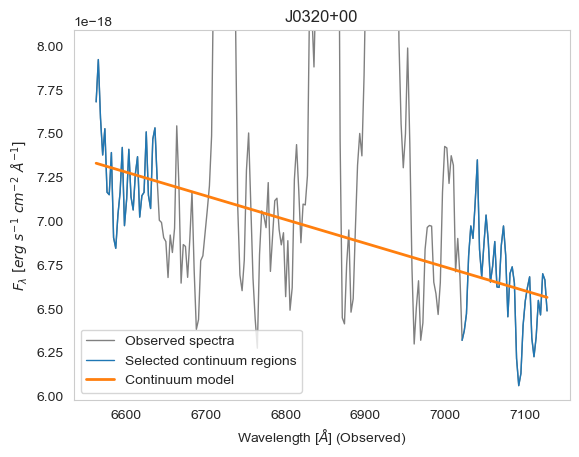

In [5]:
# Define the regions where to fit the continuum
w1c = 6560 * u.angstrom #segment on the left
w2c = 6640 * u.angstrom
w3c = 7020 * u.angstrom #on the right
w4c = 7130 * u.angstrom

# Fit the continuum and estimate the noise
wlimits_cont = ([w1c,w2c],[w3c,w4c])
mask_cont = (wave > w1c) & (wave < w4c)
poly_cont,noise=fit_continuum(wave,flux,wlimits_cont)

# For plotting the chosen region of continuum
wave_cont = wave[mask_cont]
flux_cont = flux[mask_cont]
flux_cont_model = poly_cont(wave_cont)
mask_cont_blue = (wave > w1c) & (wave < w2c)   
mask_cont_red = (wave > w3c) & (wave < w4c)

sns.set_palette('tab10',8)
xlabel=r"Wavelength [$\AA$] (Observed)"
ylabel='$F_\lambda$ $[erg\ s^{-1}\ cm^{-2}\ \AA^{-1}]$'
plt.plot(wave_cont,flux_cont*norm,linewidth=1,color="gray",label="Observed spectra")
plt.plot(wave[mask_cont_blue],flux[mask_cont_blue]*norm,label='Selected continuum regions',color=sns.color_palette('tab10')[0],linewidth=1)
plt.plot(wave[mask_cont_red],flux[mask_cont_red]*norm,color=sns.color_palette('tab10')[0],linewidth=1)
plt.plot(wave_cont,flux_cont_model*norm,label='Continuum model',color=sns.color_palette('tab10')[1],linewidth=2)
plt.legend()
plt.grid()
plt.ylim(np.median(flux_cont*norm.value)-0.15*np.median(flux_cont*norm.value),np.median(flux_cont*norm.value)+0.15*np.median(flux_cont*norm.value))
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(tgt_name)

##### Modeling of the [OIII]5007 emission line

In [6]:
# Define the line region
w1 = 6880 *u.angstrom #below [OIII]5007
w2 = 5050*(1+redshift) *u.angstrom #above [OIII]5007
mask = (wave > w1) & (wave < w2) 

flux_reg = flux[mask] #Flux in the line region
wave_reg = wave[mask] #Line region
cont_reg_model = poly_cont(wave_reg)  #Continuum contribution in the line region
flux_reg_nocont=flux_reg - cont_reg_model #Flux without the continuum

# Define the initial parameters for the model
wave_O3b = 5007*(1+redshift)*u.angstrom
wave_O3r = 4959*(1+redshift)*u.angstrom
stddev_n = 5*u.angstrom #sigma
amp_O3b = flux_reg_nocont[np.argmin(abs(wave_reg-wave_O3b))] #flux of the nearest point to the central position of the line (wave_o3)

In [7]:
# Choosing the gaussian components for each emission line
c1 = models.Gaussian1D(amplitude=amp_O3b/2, mean=6918, stddev=stddev_n/2,name='[OIII]5007n1')
c2 = models.Gaussian1D(amplitude=amp_O3b/2, mean=6926, stddev=stddev_n/2,name='[OIII]5007n2')
c3 = models.Gaussian1D(amplitude=amp_O3b/5, mean=6919, stddev=3*stddev_n,name='[OIII]5007i')
c4 = models.Gaussian1D(amplitude=amp_O3b/15, mean=6955, stddev=stddev_n/3,name='[OIII]5007r')

# Conditions to the gaussian amplitudes
c1.amplitude.bounds=(0,None)
c2.amplitude.bounds=(0,None)
c3.amplitude.bounds=(0,None)
c4.amplitude.bounds=(0,None)

# Condition for the red bump on the standard deviation due to the instrumental FWHM
c4.mean.bounds=(6938,None)
c4.stddev.bounds=(tgt_info['intFWHM'][0]/np.sqrt(8*np.log(2.)),None)

line_combo = c1 + c2 + c3 + c4 #Gaussians to fit



Initial parameters of the parametric model [1.62992422e+00 6.92159070e+03 8.02577285e+00 1.00804475e+00
 6.92663694e+03 4.64851824e+00 1.04780665e+00 6.92052615e+03
 1.02903613e+01 1.66820573e-01 6.95289045e+03 2.45284136e+00]


Initial velocities of the non-parametric analysis [6924.23895808  983.19979683 -103.25729852 -751.89466017  545.38006314
  -69.07179973  -69.23686309]


 -------- 


 Executing simulation


[OIII]5007n1
5.191565140201753e-16 erg / (A cm2 s) 1.0196232413042066 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6920.17 +/- 2.50
 FWHM= 8.051e+02 km / s +/- 7.622e+01 km / s
 Flux= 5.192e-16 erg / (A cm2 s) +/- 1.095e-16 Angstrom erg / (A cm2 s)
 EW= 28.60 +/- 6.03 Angstrom
 
[OIII]5007n2
2.3898544276600005e-16 erg / (A cm2 s) 1.0185210037733108 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6926.42 +/- 0.63
 FWHM= 5.079e+02 km / s +/- 6.088e+01 km / s
 Flux= 2.390e-16 erg / (A cm2 s) +/- 9.152e-17 Angstrom erg / (A cm2 s)
 EW= 13.18 +/- 5.05 Angstrom
 
[OIII]5007i
5.378848023927224e-16 erg / (A cm2 s) 1.0196232413042066 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6921.48 +/- 1.78
 FWHM= 9.674e+02 km / s +/- 1.791e+02 km / s
 Flux= 5.379e-16 erg / (A cm2 s) +/- 1.778e-16 Angstrom erg / (A cm2 s)
 EW= 29.64 +/- 9.79 Angstrom
 
[OIII]5007r
1.8136521684411924e-17 erg / (A cm2 s) 1.0130098161188326 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6952.90 +/- 0.59
 FWHM= 2.491e+02

Reduced chi-squared:  146.85337129147103




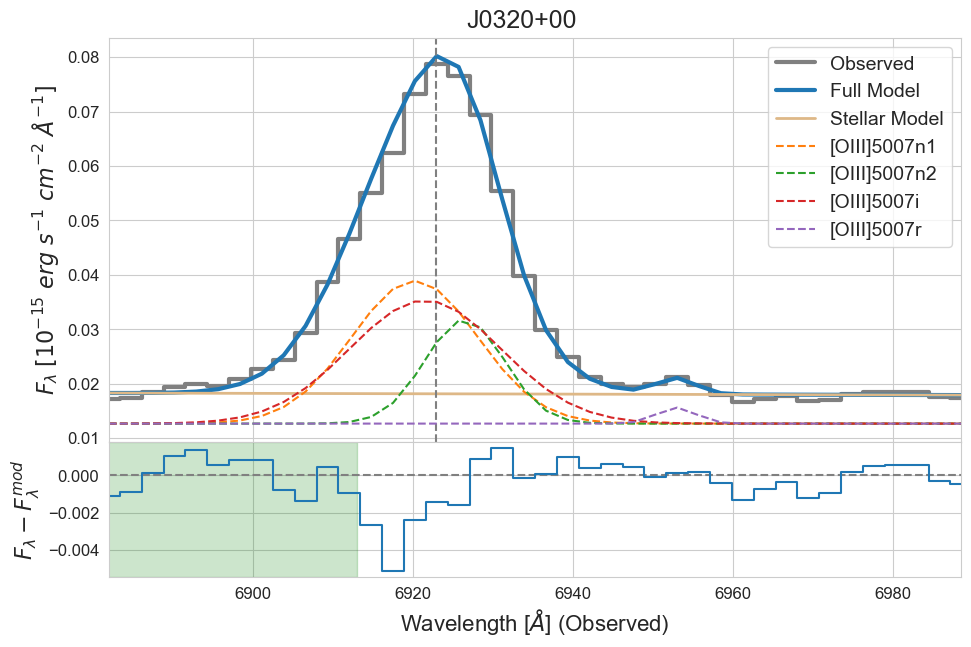

In [8]:
# Perfom the fit to the model
sns.set_palette('tab10',8)
line_combo_fit_5007,line_combo_error_5007,line_tab,chi2_5007,blueshift_5007,eblueshift_5007, nonpar_fit_5007, nonpar_error_5007,\
outflow_fit_5007, outflow_error_5007, outflow_blue_fit_5007, outflow_blue_error_5007, outflow_red_fit_5007, outflow_red_error_5007,\
params_simul_5007, params_simul_nonpar_5007 = perform_fit_plot(wave_reg,flux_reg,cont_reg_model,wave_O3r,wave_O3b,\
          line_combo,noise,Nsimul=1000,plotfile=plotfile,logfile=logfile,flux_norm=norm*(1+redshift)**3,tgt_name=tgt_name)
                    
print('Reduced chi-squared: ',chi2_5007)
print('\n')

#### Simulated distributions

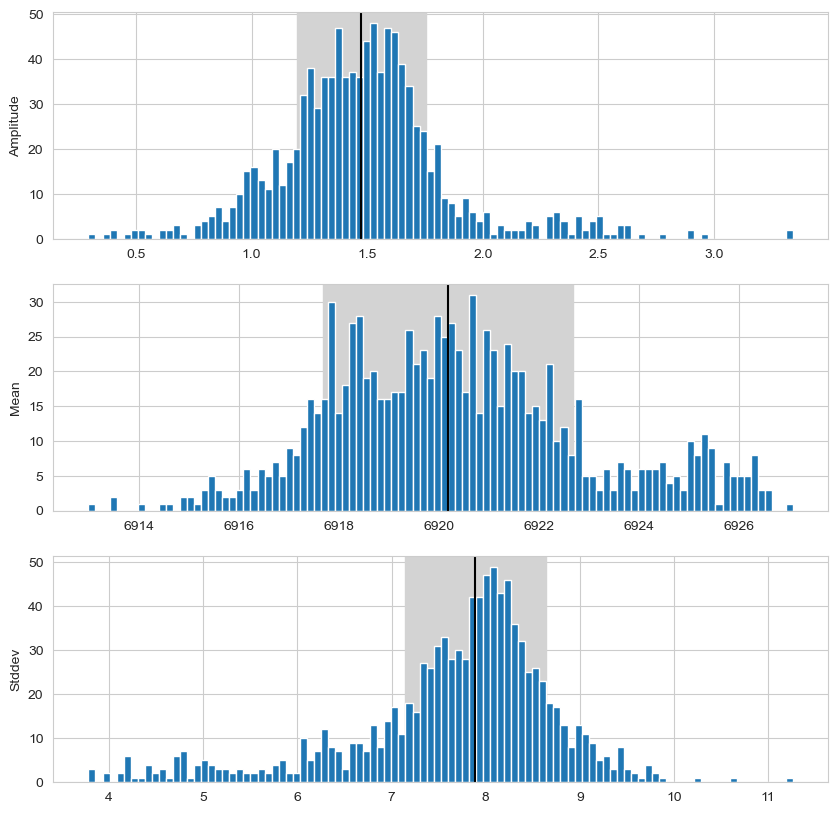

In [9]:
# Checking the simulated normal distributions for the parameters of the first modeled component
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))
ax1.axvspan(line_combo_fit_5007.parameters[0]-line_combo_error_5007.parameters[0],line_combo_fit_5007.parameters[0]+line_combo_error_5007.parameters[0],color='lightgrey')
ax1.hist(params_simul_5007[0],bins=100)
ax1.axvline(line_combo_fit_5007.parameters[0],color='black')
ax1.set_ylabel('Amplitude')

ax2.axvspan(line_combo_fit_5007.parameters[1]-line_combo_error_5007.parameters[1],line_combo_fit_5007.parameters[1]+line_combo_error_5007.parameters[1],color='lightgrey')
ax2.hist(params_simul_5007[1],bins=100)
ax2.axvline(line_combo_fit_5007.parameters[1],color='black')
ax2.set_ylabel('Mean')

ax3.axvspan(line_combo_fit_5007.parameters[2]-line_combo_error_5007.parameters[2],line_combo_fit_5007.parameters[2]+line_combo_error_5007.parameters[2],color='lightgrey')
ax3.hist(params_simul_5007[2],bins=100)
ax3.axvline(line_combo_fit_5007.parameters[2],color='black')
ax3.set_ylabel('Stddev')
plt.show()


Text(0, 0.5, 'Asymmetry')

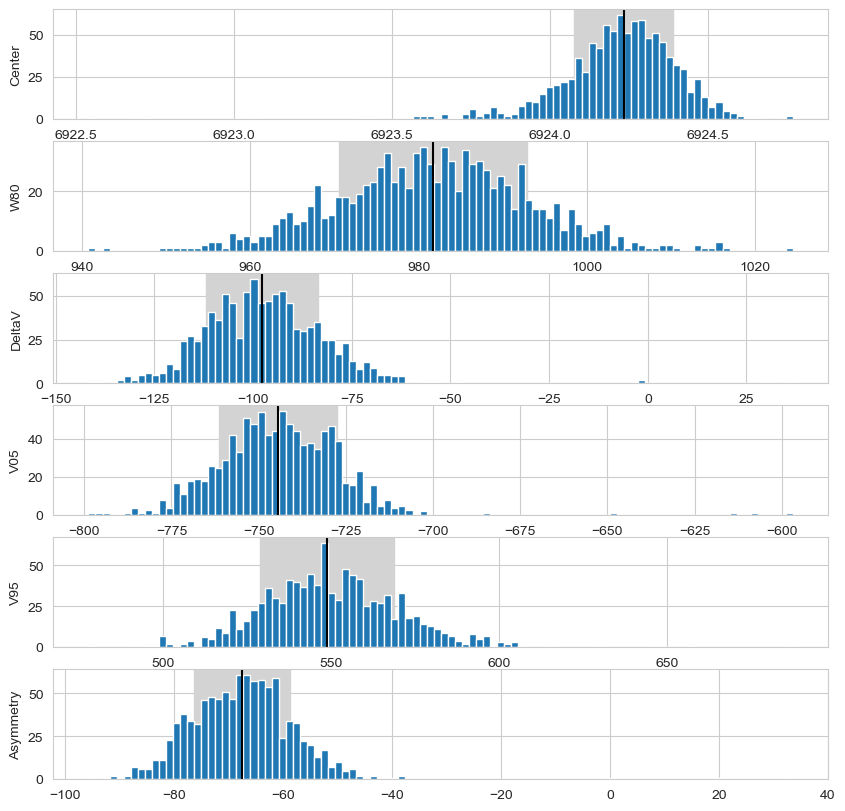

In [10]:
# Checking the simulated normal distributions for the non-parametric velocites
f,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(10,10))
ax1.axvspan(nonpar_fit_5007[0]-nonpar_error_5007[0],nonpar_fit_5007[0]+nonpar_error_5007[0],color='lightgrey')
ax1.hist(params_simul_nonpar_5007[0],bins=100)
ax1.axvline(nonpar_fit_5007[0],color='black')
ax1.set_ylabel('Center')

ax2.axvspan(nonpar_fit_5007[1]-nonpar_error_5007[1],nonpar_fit_5007[1]+nonpar_error_5007[1],color='lightgrey')
ax2.hist(params_simul_nonpar_5007[1],bins=100)
ax2.axvline(nonpar_fit_5007[1],color='black')
ax2.set_ylabel('W80')

ax3.axvspan(nonpar_fit_5007[2]-nonpar_error_5007[2],nonpar_fit_5007[2]+nonpar_error_5007[2],color='lightgrey')
ax3.hist(params_simul_nonpar_5007[2],bins=100)
ax3.axvline(nonpar_fit_5007[2],color='black')
ax3.set_ylabel('DeltaV')

ax4.axvspan(nonpar_fit_5007[3]-nonpar_error_5007[3],nonpar_fit_5007[3]+nonpar_error_5007[3],color='lightgrey')
ax4.hist(params_simul_nonpar_5007[3],bins=100)
ax4.axvline(nonpar_fit_5007[3],color='black')
ax4.set_ylabel('V05')

ax5.axvspan(nonpar_fit_5007[4]-nonpar_error_5007[4],nonpar_fit_5007[4]+nonpar_error_5007[4],color='lightgrey')
ax5.hist(params_simul_nonpar_5007[4],bins=100)
ax5.axvline(nonpar_fit_5007[4],color='black')
ax5.set_ylabel('V95')

ax6.axvspan(nonpar_fit_5007[6]-nonpar_error_5007[6],nonpar_fit_5007[6]+nonpar_error_5007[6],color='lightgrey')
ax6.hist(params_simul_nonpar_5007[6],bins=100)
ax6.axvline(nonpar_fit_5007[6],color='black')
ax6.set_ylabel('Asymmetry')

#### Parametric model of the [OIII]5007 emission line

In [11]:
table = QTable(names=('LineID', 'Center', 'eCenter','Flux','eFlux','FWHM','eFWHM','EW','eEW'), \
           dtype=('U12','f4', 'f4','f4', 'f4','f4', 'f4','f4','f4'))
table_par_0 = table_add_model(line_combo_fit_5007,table)
table_par_0.add_column(blueshift_5007,name='Blueshift')
table_par_0.add_column(eblueshift_5007,name='eBlueshift')

In [12]:
table_par_0

LineID,Center,eCenter,Flux,eFlux,FWHM,eFWHM,EW,eEW,Blueshift,eBlueshift
str12,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
[OIII]5007n1,6920.1743,2.4978552,5.191565e-16,1.0950296e-16,805.14435,76.224846,28.60316,6.0331144,-114.08725263213944,108.20851290347926
[OIII]5007n2,6926.42,0.6273183,2.3898545e-16,9.15233e-17,507.9126,60.879814,13.181259,5.047974,156.48438435561573,27.175789347623333
[OIII]5007i,6921.4844,1.7830501,5.378848e-16,1.7776246e-16,967.42633,179.07825,29.635004,9.793902,-57.32817895158664,77.24274782538149
[OIII]5007r,6952.902,0.58657897,1.8136522e-17,3.5621218e-18,249.1366,0.0,1.0057633,0.19753796,1303.6986291939095,25.410935975428337


#### Non parametric analysis of the [OIII]5007 emission line

In [13]:
table_nonpar_0 = QTable(names=('Name', 'Wavepeak', 'Width80','DeltaV','V05','V95','Vmed','Asymmetry'),\
           dtype=('U12','f4', 'f4','f4','f4','f4','f4','f4'))
table_nonpar_0.add_row(np.append(tgt_name,nonpar_fit_5007))
table_nonpar_0.add_columns(np.array(nonpar_error_5007,dtype='f4'),indexes=[2,3,4,5,6,7,8],names=('eWavepeak', 'eWidth80','eDeltaV','eV05','eV95','eVmed','eAsymmetry'))

In [14]:
table_nonpar_0

Name,Wavepeak,eWavepeak,Width80,eWidth80,DeltaV,eDeltaV,V05,eV05,V95,eV95,Vmed,eVmed,Asymmetry,eAsymmetry
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0320+00,6924.233,0.15645073,981.73413,11.156988,-97.70197,14.292393,-744.4113,16.925049,548.71375,19.949896,-67.586525,6.9734,-67.58154,8.8715105


### Model for both the [OIII]5007 emission lines



#### Parametric model

In [15]:
# Define the both lines region
w1 = 4900*(1+redshift) *u.angstrom #below [OIII]4959
w2 = 5050*(1+redshift) *u.angstrom #above [OIII]5007
mask = (wave > w1) & (wave < w2) 

flux_reg = flux[mask] #Flux in the line region
wave_reg = wave[mask] #Line region
cont_reg_model = poly_cont(wave_reg)  #Continuum contribution in the line region
flux_reg_nocont=flux_reg - cont_reg_model #Flux without the continuum

In [16]:
# Models for both emission lines
mean_5007n1=table_par_0['Center'][0]
stddev_5007n1=table_par_0['FWHM'][0]/(2.999e5*np.sqrt(8*np.log(2))/mean_5007n1)
amp_5007n1=table_par_0['Flux'][0]/(np.sqrt(2*np.pi)*stddev_5007n1*norm*(1+redshift)**3/(u.erg/(u.A*u.s*u.cm*u.cm)))
mean_5007n2=table_par_0['Center'][1]
stddev_5007n2=table_par_0['FWHM'][1]/(2.999e5*np.sqrt(8*np.log(2))/mean_5007n2)
amp_5007n2=table_par_0['Flux'][1]/(np.sqrt(2*np.pi)*stddev_5007n2*norm*(1+redshift)**3/(u.erg/(u.A*u.s*u.cm*u.cm)))
mean_5007i=table_par_0['Center'][2]
stddev_5007i=table_par_0['FWHM'][2]/(2.999e5*np.sqrt(8*np.log(2))/mean_5007i)
amp_5007i=table_par_0['Flux'][2]/(np.sqrt(2*np.pi)*stddev_5007i*norm*(1+redshift)**3/(u.erg/(u.A*u.s*u.cm*u.cm)))
mean_5007r=table_par_0['Center'][3]
stddev_5007r=table_par_0['FWHM'][3]/(2.999e5*np.sqrt(8*np.log(2))/mean_5007r)
amp_5007r=table_par_0['Flux'][3]/(np.sqrt(2*np.pi)*stddev_5007r*norm*(1+redshift)**3/(u.erg/(u.A*u.s*u.cm*u.cm)))

c1 = models.Gaussian1D(amplitude=amp_5007n1, mean=mean_5007n1, stddev=stddev_5007n1,name='[OIII]5007n1')
c2 = models.Gaussian1D(name='[OIII]4959n1')
c3 = models.Gaussian1D(amplitude=amp_5007n2, mean=mean_5007n2, stddev=stddev_5007n2,name='[OIII]5007n2')
c4 = models.Gaussian1D(name='[OIII]4959n2')
c5 = models.Gaussian1D(amplitude=amp_5007i, mean=mean_5007i, stddev=stddev_5007i,name='[OIII]5007i') #broad=ancha
c6 = models.Gaussian1D(name='[OIII]4959i') 
c7 = models.Gaussian1D(amplitude=amp_5007r, mean=mean_5007r, stddev=stddev_5007r,name='[OIII]5007r') #broad=ancha
c8 = models.Gaussian1D(name='[OIII]4959r') 

# We force the [OIII]5007 line to have the values obtained by the previous fit
c1.stddev.fixed= True
c1.amplitude.fixed= True
c1.mean.fixed = True
c3.stddev.fixed= True
c3.amplitude.fixed= True
c3.mean.fixed = True
c5.stddev.fixed= True
c5.amplitude.fixed= True
c5.mean.fixed = True
c7.stddev.fixed= True
c7.amplitude.fixed= True
c7.mean.fixed = True

#And we force the [OIII]4959 line to verify the relations
c2.mean.tied = tie_center_OIIIn1 #solidarity
c2.stddev.tied = tie_stddevn_OIIIn1 #same kinematic fwhm
c2.amplitude.tied = tie_ampl_OIIIn1 #ratio between the line (amplitude)
c4.mean.tied = tie_center_OIIIn2 #solidarity 
c4.stddev.tied = tie_stddevn_OIIIn2 #same kinematic fwhm
c4.amplitude.tied = tie_ampl_OIIIn2 #ratio between the line (amplitude)
c6.mean.tied = tie_center_OIIIi #solidarity 
c6.stddev.tied = tie_stddevn_OIIIi #same kinematic fwhm
c6.amplitude.tied = tie_ampl_OIIIi #ratio between the line (amplitude)
c8.mean.tied = tie_center_OIIIr #solidarity 
c8.stddev.tied = tie_stddevn_OIIIr #same kinematic fwhm
c8.amplitude.tied = tie_ampl_OIIIr #ratio between the line (amplitude)

line_combo = c1 + c2 + c3 + c4 + c5 +c6 + c7 + c8 #Gaussians to fit



Initial parameters of the parametric model [1.47471199e+00 6.92017432e+03 7.88962921e+00 4.91570663e-01
 6.85392543e+03 7.81409944e+00 1.07516064e+00 6.92641992e+03
 4.98153989e+00 3.58386879e-01 6.86011124e+03 4.93385013e+00
 1.27136965e+00 6.92148438e+03 9.48162897e+00 4.23789884e-01
 6.85522294e+03 9.39085851e+00 1.65710522e-01 6.95290186e+03
 2.45284123e+00 5.52368405e-02 6.88633965e+03 2.42935945e+00]


Initial velocities of the non-parametric analysis [6923.61613724  954.98916137  -78.08872448 -702.85805654  546.68060759
  -57.08135372  -48.65589451]


 -------- 


 Executing simulation


[OIII]5007n1
5.191564989488501e-16 erg / (A cm2 s) 1.0196232413042066 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6920.17 +/- 0.00
 FWHM= 8.051e+02 km / s +/- 0.000e+00 km / s
 Flux= 5.192e-16 erg / (A cm2 s) +/- 0.000e+00 Angstrom erg / (A cm2 s)
 EW= 28.60 +/- 0.00 Angstrom
 
[OIII]4959n1
1.7139548636129532e-16 erg / (A cm2 s) 1.0328500916749543 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6853.93 +/- 0.00
 FWHM= 8.051e+02 km / s +/- 0.000e+00 km / s
 Flux= 1.714e-16 erg / (A cm2 s) +/- 0.000e+00 Angstrom erg / (A cm2 s)
 EW= 9.32 +/- 0.00 Angstrom
 
[OIII]5007n2
2.3898544915857453e-16 erg / (A cm2 s) 1.0185210037733108 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6926.42 +/- 0.00
 FWHM= 5.079e+02 km / s +/- 0.000e+00 km / s
 Flux= 2.390e-16 erg / (A cm2 s) +/- 0.000e+00 Angstrom erg / (A cm2 s)
 EW= 13.18 +/- 0.00 Angstrom
 
[OIII]4959n2
7.889919007994966e-17 erg / (A cm2 s) 1.0317478541440588 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6860.11 +/- 0.00
 FWHM= 5.079e+0

Reduced chi-squared:  387.5530459067752




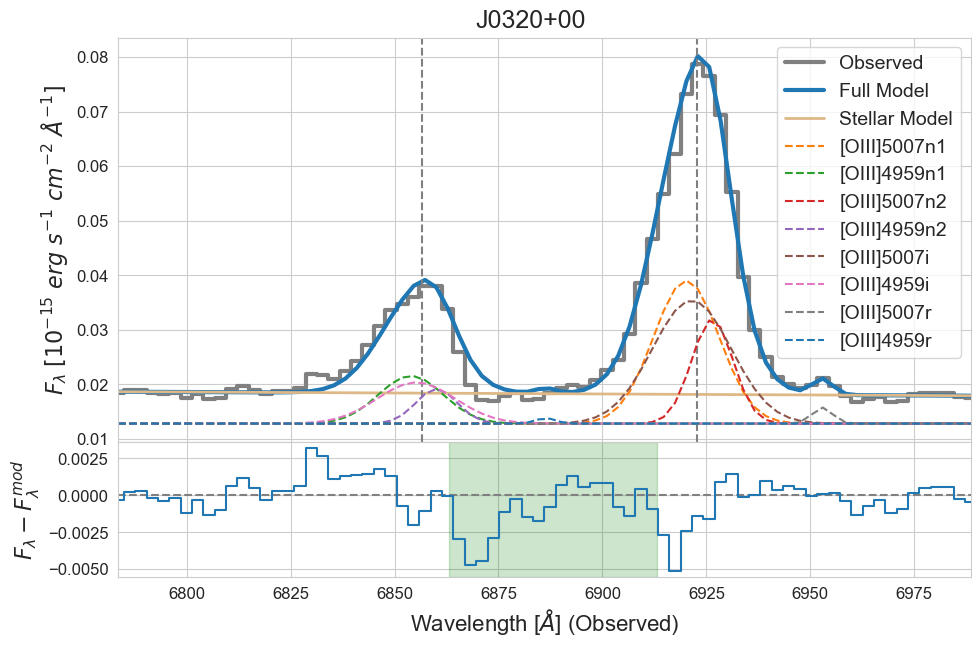

In [17]:
# Perfom the fit to the model
sns.set_palette('tab10',8)
line_combo_fit, line_combo_error, line_tab, chi2, blueshift, eblueshift, nonpar_fit, nonpar_error,\
outflow_fit, outflow_error, outflow_blue_fit, outflow_blue_error, outflow_red_fit, outflow_red_error,\
params_simul, params_simul_nonpar = perform_fit_plot(wave_reg,flux_reg,cont_reg_model,wave_O3r,wave_O3b,\
          line_combo,noise,Nsimul=1000,plotfile=plotfile,logfile=logfile,flux_norm=norm*(1+redshift)**3,tgt_name=tgt_name)
                    
print('Reduced chi-squared: ',chi2)
print('\n')

In [18]:
# Table with the fitting parameters for each component of each line
table = QTable(names=('LineID', 'Center', 'eCenter','Flux','eFlux','FWHM','eFWHM','EW','eEW'), \
           dtype=('U12','f4', 'f4','f4', 'f4','f4', 'f4','f4','f4'))
table_par = table_add_model(line_combo_fit,table)

# Blueshift of each component
table_par.add_column(blueshift,name='Blueshift')
table_par.add_column(eblueshift,name='eBlueshift')

# For the error estimation
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        for j in range(len(table_par_0['LineID'])):
            if table_par['LineID'][i][-1]==table_par_0['LineID'][j][-1]:
                table_par['eCenter'][i]=5006.843*table_par_0['eCenter'][j]/4958.911
                table_par['eFlux'][i]=3*table_par_0['eFlux'][j]
                table_par['eFWHM'][i]=table_par_0['eFWHM'][j]
                table_par['eEW'][i]=table_par_0['eEW'][j]
                table_par['Blueshift'][i]=table_par_0['Blueshift'][j]
                table_par['eBlueshift'][i]=table_par_0['eBlueshift'][j]
    if table_par['LineID'][i][:10]=='[OIII]4959':
        for j in range(len(table_par_0['LineID'])):
            if table_par['LineID'][i][-1]==table_par_0['LineID'][j][-1]:
                table_par['eCenter'][i]=table_par_0['eCenter'][j]
                table_par['eFlux'][i]=table_par_0['eFlux'][j]
                table_par['eFWHM'][i]=table_par_0['eFWHM'][j]
                table_par['eEW'][i]=table_par_0['eEW'][j]
                table_par['Blueshift'][i]=table_par_0['Blueshift'][j]
                table_par['eBlueshift'][i]=table_par_0['eBlueshift'][j]

# Add name
table_par.add_column(tgt_name,index=0,name='Name')

# Remove non-needed ones
table_par.remove_columns(['Center','eCenter','EW','eEW',])

# Luminosity and flux percentage
table_par.add_column(np.zeros(len(table_par['LineID'])),name='Luminosity')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='eLuminosity')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='Percentage')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='ePercentage')

Flux_4959=[]
Flux_5007=[]
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        Flux_5007.append(table_par['Flux'][i])

    if table_par['LineID'][i][:10]=='[OIII]4959':
        Flux_4959.append(table_par['Flux'][i])

for i in range(len(table_par['LineID'])):
    table_par['Luminosity'][i]=table_par['Flux'][i]*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2
    table_par['eLuminosity'][i]=table_par['eFlux'][i]*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2

    if table_par['LineID'][i][:10]=='[OIII]5007':				
        table_par['Percentage'][i]=table_par['Flux'][i]/np.sum(Flux_5007)
        table_par['ePercentage'][i]=table_par['eFlux'][i]/np.sum(Flux_5007)

    if table_par['LineID'][i][:10]=='[OIII]4959':				
        table_par['Percentage'][i]=table_par['Flux'][i]/np.sum(Flux_4959)
        table_par['ePercentage'][i]=table_par['eFlux'][i]/np.sum(Flux_4959)

In [19]:
table_par

Name,LineID,Flux,eFlux,FWHM,eFWHM,Blueshift,eBlueshift,Luminosity,eLuminosity,Percentage,ePercentage
str8,str12,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
J0320+00,[OIII]5007n1,5.191565e-16,3.2850886e-16,805.14435,76.224846,-114.08725263213944,108.20851290347926,2.662045420834962e+41,1.6844737947614788e+41,0.3950471878051758,0.24997568130493164
J0320+00,[OIII]4959n1,1.7139549e-16,1.0950296e-16,805.14435,76.224846,-114.08725263213944,108.20851290347926,8.788536357135578e+40,5.614912762311086e+40,0.3950471878051758,0.25239190459251404
J0320+00,[OIII]5007n2,2.3898545e-16,2.745699e-16,507.9126,60.879814,156.48438435561573,27.175789347623333,1.2254303314451053e+41,1.4078944954465507e+41,0.18185369670391083,0.2089313566684723
J0320+00,[OIII]4959n2,7.8899193e-17,9.15233e-17,507.9126,60.879814,156.48438435561573,27.175789347623333,4.04566324061327e+40,4.692981425276188e+40,0.18185369670391083,0.2109508365392685
J0320+00,[OIII]5007i,5.378848e-16,5.332874e-16,967.42633,179.07825,-57.32817895158664,77.24274782538149,2.7580774340495406e+41,2.734503486932804e+41,0.4092983305454254,0.4057999551296234
J0320+00,[OIII]4959i,1.775785e-16,1.7776246e-16,967.42633,179.07825,-57.32817895158664,77.24274782538149,9.10557856964152e+40,9.115011623109347e+40,0.409298300743103,0.40972232818603516
J0320+00,[OIII]5007r,1.8136522e-17,1.0686365e-17,249.1366,0.0,1303.6986291939095,25.410935975428337,9.299747965381894e+39,5.479578898880442e+39,0.01380081381648779,0.00813168752938509
J0320+00,[OIII]4959r,5.987632e-18,3.5621218e-18,249.1366,0.0,1303.6986291939095,25.410935975428337,3.070239619216767e+39,1.826526299626814e+39,0.013800812885165215,0.008210287429392338


In [20]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/parametric.txt').to_pandas()
parametric = file.drop(file[file['Name']==tgt_name].index).append(table_par.to_pandas())
ascii.write(QTable.from_pandas(parametric.sort_values('Name')), 'Tables/parametric.txt', format='csv', overwrite = True, formats={'Flux':'%8.2e','eFlux':'%8.2e','FWHM': '%8.1f','eFWHM':'%8.1f','Blueshift': '%8.2f','eBlueshift':'%8.2f','Luminosity': '%8.2e','eLuminosity':'%8.2e','Percentage': '%8.3f','ePercentage':'%8.3f'})

C:\Users\HP\AppData\Local\Temp\ipykernel_3112\2174204615.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parametric = file.drop(file[file['Name']==tgt_name].index).append(table_par.to_pandas())


In [21]:
table_5007 = QTable(names=('Name','LineID','Flux','eFlux','FWHM','eFWHM','Blueshift','eBlueshift','Luminosity','eLuminosity','Percentage','ePercentage'), \
           dtype=('U12','U12','f4', 'f4','f4', 'f4','f4', 'f4','f8','f8','f4', 'f4'))
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        table_5007.add_row(table_par[i])

# Save the results in a latex format for the 5007 line
texfile = ascii.read('Tables/parametric.tex',format='latex').to_pandas()
texparametric = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_5007.to_pandas())
ascii.write(QTable.from_pandas(texparametric.sort_values('Name')), 'Tables/parametric.tex', format='latex', overwrite = True, formats={'Flux':'%8.2e','eFlux':'%8.2e','FWHM': '%8.1f','eFWHM':'%8.1f','Blueshift': '%8.2f','eBlueshift':'%8.2f','Luminosity': '%8.3e','eLuminosity':'%8.3e','Percentage': '%8.3f','ePercentage':'%8.3f'})

C:\Users\HP\AppData\Local\Temp\ipykernel_3112\1745872242.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  texparametric = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_5007.to_pandas())


#### Non-parametric analysis

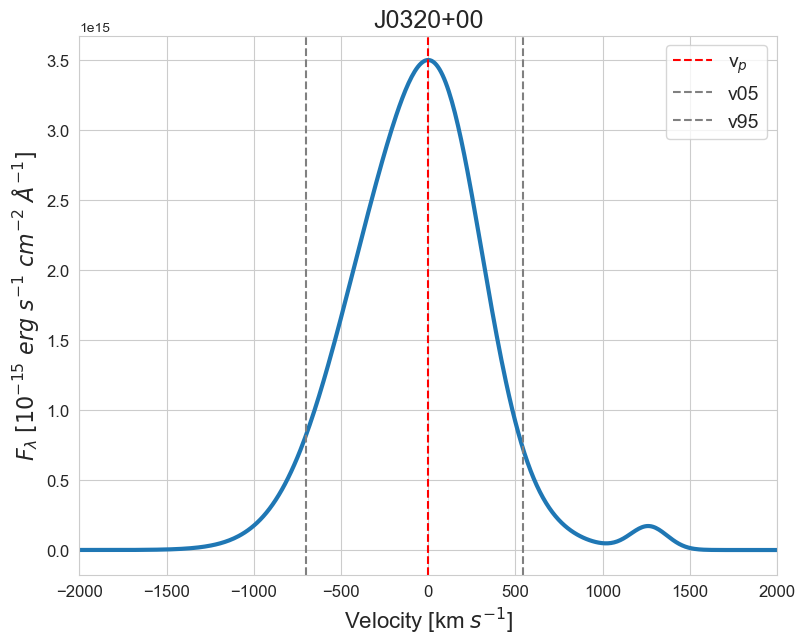

In [22]:
perform_nonpar_plot(tgt_name,wave_reg,line_combo_fit,nonpar_fit,flux_norm=norm*(1+redshift)**3)

In [23]:
table_nonpar = QTable(names=('Name', 'Wavepeak', 'Width80','DeltaV','V05','V95','Vmed','Asymmetry'),\
           dtype=('U12','f4', 'f4','f4','f4','f4','f4','f4'))
table_nonpar.add_row(np.append(tgt_name,nonpar_fit))
table_nonpar.add_columns(np.array(nonpar_error_5007,dtype='f4'),indexes=[2,3,4,5,6,7,8],names=('eWavepeak', 'eWidth80','eDeltaV','eV05','eV95','eVmed','eAsymmetry'))

In [24]:
table_nonpar

Name,Wavepeak,eWavepeak,Width80,eWidth80,DeltaV,eDeltaV,V05,eV05,V95,eV95,Vmed,eVmed,Asymmetry,eAsymmetry
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0320+00,6923.616,0.15645073,954.98914,11.156988,-78.08872,14.292393,-702.85803,16.925049,546.6806,19.949896,-57.081352,6.9734,-48.655895,8.8715105


In [25]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/nonparametric.txt').to_pandas()
nonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())
ascii.write(QTable.from_pandas(nonparametric.sort_values('Name')), 'Tables/nonparametric.txt', format='csv', overwrite=True, \
            formats={'Name':'','Wavepeak': '%8.2f','eWavepeak': '%8.2f','Width80': '%8.2f','eWidth80': '%8.2f','DeltaV': '%8.2f','eDeltaV': '%8.2f','V05': '%8.2f','eV05': '%8.2f','V95': '%8.2f','eV95': '%8.2f','Vmed': '%8.2f','eVmed': '%8.2f','Asymmetry': '%8.2f','eAsymmetry': '%8.2f'})

C:\Users\HP\AppData\Local\Temp\ipykernel_3112\3507166913.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())


In [26]:
# Save the results in a latex format
file = ascii.read('Tables/nonparametric.tex').to_pandas()
texnonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())
ascii.write(QTable.from_pandas(texnonparametric.sort_values('Name')), 'Tables/nonparametric.tex', format='latex', overwrite=True, \
            formats={'Name':'','Wavepeak': '%8.2f','eWavepeak': '%8.2f','Width80': '%8.2f','eWidth80': '%8.2f','DeltaV': '%8.2f','eDeltaV': '%8.2f','V05': '%8.2f','eV05': '%8.2f','V95': '%8.2f','eV95': '%8.2f','Vmed': '%8.2f','eVmed': '%8.2f','Asymmetry': '%8.2f','eAsymmetry': '%8.2f'})


C:\Users\HP\AppData\Local\Temp\ipykernel_3112\64017041.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  texnonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())


# Outflow mass, outflow mass rate and energy rate

We have decided to ignore the feature due to the red bump when calculating the AGN-driven outflow and its properties.
So we need to perform again the Parametric modeling of the emission lines.

In [27]:
line_combo = c1 + c2 + c3 + c4 + c5 + c6 #Gaussians to fit



Initial parameters of the parametric model [1.47471199e+00 6.92017432e+03 7.88962921e+00 4.91570663e-01
 6.85392543e+03 7.81409944e+00 1.07516064e+00 6.92641992e+03
 4.98153989e+00 3.58386879e-01 6.86011124e+03 4.93385013e+00
 1.27136965e+00 6.92148438e+03 9.48162897e+00 4.23789884e-01
 6.85522294e+03 9.39085851e+00]


Initial velocities of the non-parametric analysis [6923.61613724  932.89541533 -105.29611843 -705.51290992  494.92067305
  -63.47077444  -64.26899944]


 -------- 


 Executing simulation


[OIII]5007n1
5.191564989488501e-16 erg / (A cm2 s) 1.0196232413042066 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6920.17 +/- 0.00
 FWHM= 8.051e+02 km / s +/- 0.000e+00 km / s
 Flux= 5.192e-16 erg / (A cm2 s) +/- 0.000e+00 Angstrom erg / (A cm2 s)
 EW= 28.60 +/- 0.00 Angstrom
 
[OIII]4959n1
1.7139548636129532e-16 erg / (A cm2 s) 1.0328500916749543 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6853.93 +/- 0.00
 FWHM= 8.051e+02 km / s +/- 0.000e+00 km / s
 Flux= 1.714e-16 erg / (A cm2 s) +/- 0.000e+00 Angstrom erg / (A cm2 s)
 EW= 9.32 +/- 0.00 Angstrom
 
[OIII]5007n2
2.3898544915857453e-16 erg / (A cm2 s) 1.0185210037733108 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6926.42 +/- 0.00
 FWHM= 5.079e+02 km / s +/- 0.000e+00 km / s
 Flux= 2.390e-16 erg / (A cm2 s) +/- 0.000e+00 Angstrom erg / (A cm2 s)
 EW= 13.18 +/- 0.00 Angstrom
 
[OIII]4959n2
7.889919007994966e-17 erg / (A cm2 s) 1.0317478541440588 1.7801006430908644e-17 erg / (A cm2 s)
 Center= 6860.11 +/- 0.00
 FWHM= 5.079e+0

Reduced chi-squared:  415.212245467346




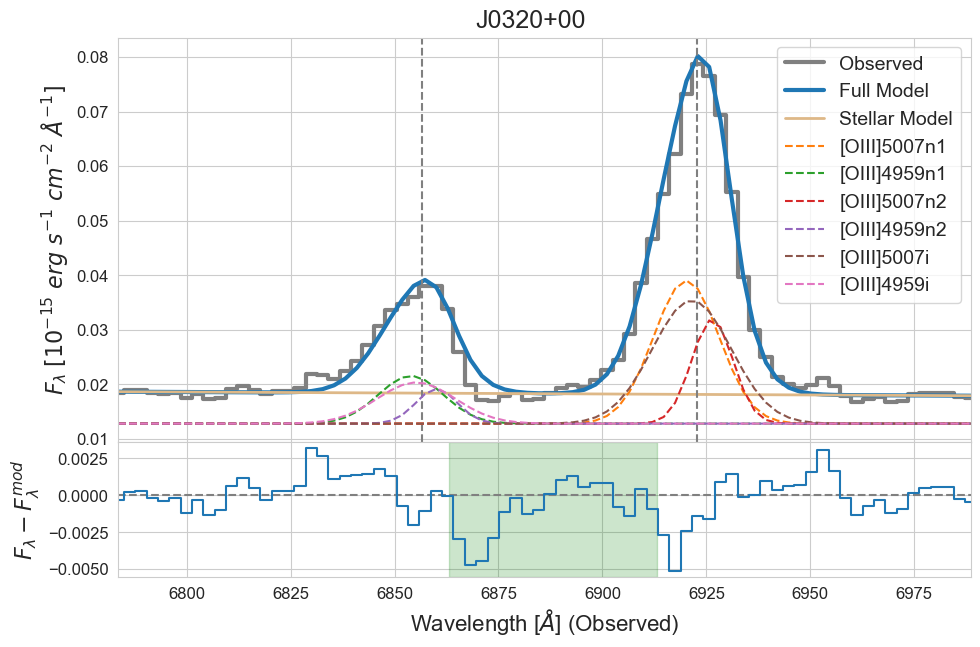

In [28]:
# Perfom the fit to the model
sns.set_palette('tab10',8)
line_combo_fit, line_combo_error, line_tab, chi2, blueshift, eblueshift, nonpar_fit, nonpar_error,\
outflow_fit, outflow_error, outflow_blue_fit, outflow_blue_error, outflow_red_fit, outflow_red_error,\
params_simul, params_simul_nonpar = perform_fit_plot(wave_reg,flux_reg,cont_reg_model,wave_O3r,wave_O3b,\
          line_combo,noise,Nsimul=1000,plotfile=plotfile,logfile=logfile,flux_norm=norm*(1+redshift)**3,tgt_name=tgt_name)
                    
print('Reduced chi-squared: ',chi2)
print('\n')

## Giovanna's method: outflow line flux

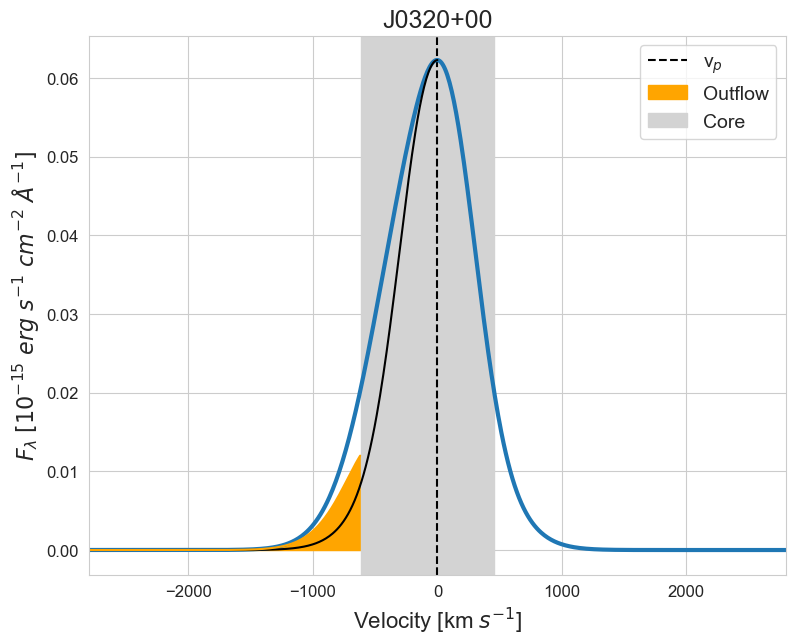

In [29]:
perform_outflow_plot(tgt_name,wave_reg,line_combo_fit,flux_norm=norm*(1+redshift)**3)

In [30]:
table_outflow = QTable(names=('Name','Foutflow', 'Voutflow'),\
           dtype=('U12','f8', 'f8'))
table_outflow.add_row(np.append(tgt_name,outflow_fit))
table_outflow.add_columns(np.array(outflow_error_5007,dtype='f8'),indexes=[2,3],names=('eFoutflow', 'eVoutflow'))
table_outflow.add_column(table_outflow['Foutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='Loutflow')
table_outflow.add_column(table_outflow['eFoutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='eLoutflow')

In [31]:
table_outflow

Name,Foutflow,eFoutflow,Voutflow,eVoutflow,Loutflow,eLoutflow
,,,,,,
str12,float64,float64,float64,float64,float64,float64
J0320+00,6.74838200030062e-17,7.085848930463363e-18,-768.9274819528287,17.056122391731165,3.4603244760141777e+40,3.633365225372392e+39


In [32]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_giovanna.txt').to_pandas()
outflow_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow.to_pandas())
ascii.write(QTable.from_pandas(outflow_giovanna.sort_values('Name')), 'Tables/outflow_giovanna.txt', format='csv', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_giovanna.tex').to_pandas()
tex_outflow_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_giovanna.sort_values('Name')), 'Tables/outflow_giovanna.tex', format='latex', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_3112\1200331943.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_3112\1200331943.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow.to_pandas())


#### Outflow energetics

In [33]:
outflow_energy,outflow_energy_errors = outflow_energetics_uncertainties(table_outflow,Nsimul=200)

In [34]:
table_outflow_energy = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy.add_row(np.append(tgt_name,outflow_energy))
table_outflow_energy.add_columns(np.array(outflow_energy_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [35]:
table_outflow_energy

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0320+00,4.8250594,0.04645792,53.59601,0.04875405,1.0,0.0,35.468403,0.05217531,0.15718703,0.016768316


In [36]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_giovanna.txt').to_pandas()
outflow_energy_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_giovanna.sort_values('Name')), 'Tables/outflow_energy_giovanna.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_giovanna.tex').to_pandas()
tex_outflow_energy_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_giovanna.sort_values('Name')), 'Tables/outflow_energy_giovanna.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_3112\2348874735.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_energy_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_3112\2348874735.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_energy_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())


## Non parametric method: v05 and v95

### V05 and v95

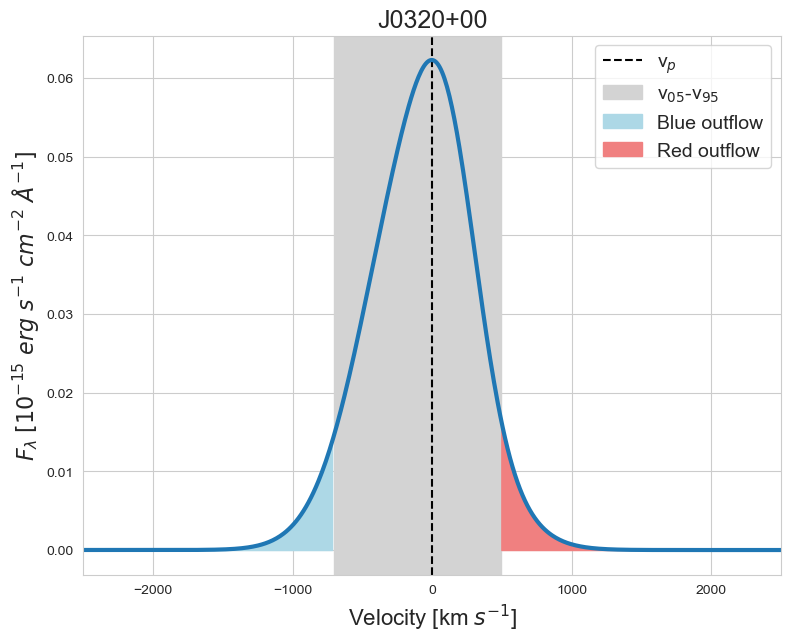

In [37]:
perform_outflow_nonpar_plot(tgt_name,wave_reg,line_combo_fit,nonpar_fit,flux_norm=norm*(1+redshift)**3)

In [38]:
table_outflow_nonpar = QTable(names=('Name','Foutflow', 'Voutflow'),\
           dtype=('U12','f8', 'f8'))
table_outflow_nonpar.add_row(np.append(tgt_name,outflow_blue_fit))
table_outflow_nonpar.add_row(np.append(tgt_name,outflow_red_fit))

table_outflow_nonpar.add_column(np.array(['Blue','Red' ]),index=1,name=('Outflow'))

table_outflow_nonpar.add_columns(np.array(np.array((outflow_blue_error_5007,outflow_red_error_5007)).T,dtype='f8'),indexes=[2,3],names=('eFoutflow', 'eVoutflow'))
table_outflow_nonpar.add_column(table_outflow_nonpar['Foutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='Loutflow')
table_outflow_nonpar.add_column(table_outflow_nonpar['eFoutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='eLoutflow')

In [39]:
table_outflow_nonpar

Name,Outflow,eFoutflow,Foutflow,eVoutflow,Voutflow,Loutflow,eLoutflow
,,,,,,,
str12,str4,float64,float64,float64,float64,float64,float64
J0320+00,Blue,8.070682229760652e-19,5.958469273302447e-17,24.14331739807616,-840.4490063492386,3.0552860026400975e+40,4.1383518681262246e+38
J0320+00,Red,7.486511795323532e-19,6.426443957038031e-17,46.09449601504159,601.4415666650988,3.2952463742096227e+40,3.838810548094764e+38


In [40]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_nonpar.txt').to_pandas()
outflow_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_nonpar.sort_values('Name')), 'Tables/outflow_nonpar.txt', format='csv', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_nonpar.tex').to_pandas()
tex_outflow_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_nonpar.sort_values('Name')), 'Tables/outflow_nonpar.tex', format='latex', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_3112\3637349706.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_3112\3637349706.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())


#### Outflow energetics

In [41]:
outflow_energy_nonpar,outflow_energy_nonpar_errors = outflow_energetics_nonpar_uncertainties(table_outflow_nonpar,200)

In [42]:
table_outflow_energy_nonpar = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy_nonpar.add_row(np.append(tgt_name,outflow_energy_nonpar))
table_outflow_energy_nonpar.add_columns(np.array(outflow_energy_nonpar_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [43]:
table_outflow_energy_nonpar

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0320+00,5.093583,0.0036484585,53.81516,0.031063037,1.0,0.0,35.68273,0.0418542,0.27270535,0.011161126


In [44]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_nonpar.txt').to_pandas()
outflow_energy_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_nonpar.sort_values('Name')), 'Tables/outflow_energy_nonpar.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_nonpar.tex').to_pandas()
tex_outflow_energy_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_nonpar.sort_values('Name')), 'Tables/outflow_energy_nonpar.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_3112\4162063144.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_energy_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_3112\4162063144.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_energy_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())


## Parametric method

In [45]:
table_outflow_par = QTable(names=('Name','Loutflow','eLoutflow', 'Voutflow','eVoutflow',),\
           dtype=('U12','f8', 'f8','f8', 'f8'))
table_outflow_par.add_row([tgt_name,table_par[(table_par['LineID']=='[OIII]5007i')]['Luminosity'],table_par[(table_par['LineID']=='[OIII]5007i')]['eLuminosity'],table_par[(table_par['LineID']=='[OIII]5007i')]['Blueshift'],table_par[(table_par['LineID']=='[OIII]5007i')]['eBlueshift']])

In [46]:
table_outflow_par

Name,Loutflow,eLoutflow,Voutflow,eVoutflow
str12,float64,float64,float64,float64
J0320+00,2.7580774340495406e+41,2.734503486932804e+41,-57.32817895158664,77.24274782538149


#### Energetics

In [47]:
outflow_energy_par,outflow_energy_par_errors = outflow_energetics_uncertainties(table_outflow_par,Nsimul=200)

C:\Users\HP\Understanding_AGN_feedback\kinematic_analysis\aux_functions.py:667: RuntimeWarning: invalid value encountered in log10
  outflow_energy = np.array([np.log10(outflow_mass/M_s),np.log10(outflow_kin_E*10**7),outflow_radio/3.086e19,np.log10(outflow_E_rate*10**2),outflow_mass_rate*3.154e7/M_s],dtype='float')


In [48]:
table_outflow_energy_par = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy_par.add_row(np.append(tgt_name,outflow_energy_par))
table_outflow_energy_par.add_columns(np.array(outflow_energy_par_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [49]:
table_outflow_energy_par

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0320+00,5.7995934,0.43572596,52.410496,1.1623265,1.0,0.0,33.197933,1.672884,0.06989436,0.16642699


In [50]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_par.txt').to_pandas()
outflow_energy_par = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_par.sort_values('Name')), 'Tables/outflow_energy_par.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_par.tex').to_pandas()
tex_outflow_energy_par = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_par.sort_values('Name')), 'Tables/outflow_energy_par.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_3112\2069511822.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_energy_par = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_3112\2069511822.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_energy_par = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())


## Comparisson of outflow energetic methods

#### Giovanna's method (1/3 total flux)

In [51]:
table_outflow_energy

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0320+00,4.8250594,0.04645792,53.59601,0.04875405,1.0,0.0,35.468403,0.05217531,0.15718703,0.016768316


#### Non parametric method (v05 and v95)

In [52]:
table_outflow_energy_nonpar

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0320+00,5.093583,0.0036484585,53.81516,0.031063037,1.0,0.0,35.68273,0.0418542,0.27270535,0.011161126


#### Parametric methods (broad component)

In [53]:
table_outflow_energy_par

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0320+00,5.7995934,0.43572596,52.410496,1.1623265,1.0,0.0,33.197933,1.672884,0.06989436,0.16642699
